In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Tuple, List, Type, Dict, Any
from timeit import default_timer as timer

In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Task 1

In [3]:
class ConvNet(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 in_channels: int = 1, 
                 out_channels = 64,
                 filters_shape: Tuple[int] = (3, 3),
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_classes = num_classes
        
        self.conv11 = torch.nn.Conv2d(self.in_channels, self.out_channels, kernel_size = 3, padding = 1, stride = 1)      # 28x28x128

        self.fc1 = torch.nn.Linear(28*28*self.out_channels, self.num_classes)
        
    def forward(self, x): 
        
        x = F.relu(self.conv11(x))

        x = x.view(-1, 28*28*self.out_channels)

        x = F.log_softmax(self.fc1(x), dim = 1)
        
        return x

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    device_name = torch.cuda.get_device_name()
    print(f'Use GPU ({device_name})')
else:
    print('Use CPU')

Use GPU (Tesla T4)


In [5]:
model = ConvNet(out_channels = 128).to(device)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

ConvNet(
  (conv11): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=10, bias=True)
)
Total number of trainable parameters 1004810


# Task 2
We will normalize our inputs to improve convergence, also it might be useful to apply random rotation,  
due to the fact that some digits are slightly tilted.

# Task 3

In [6]:
transform = tf.Compose([tf.ToTensor(), tf.RandomRotation(10), tf.Normalize((0.1307,), (0.3081))])

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=transform)

valid_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=transform)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

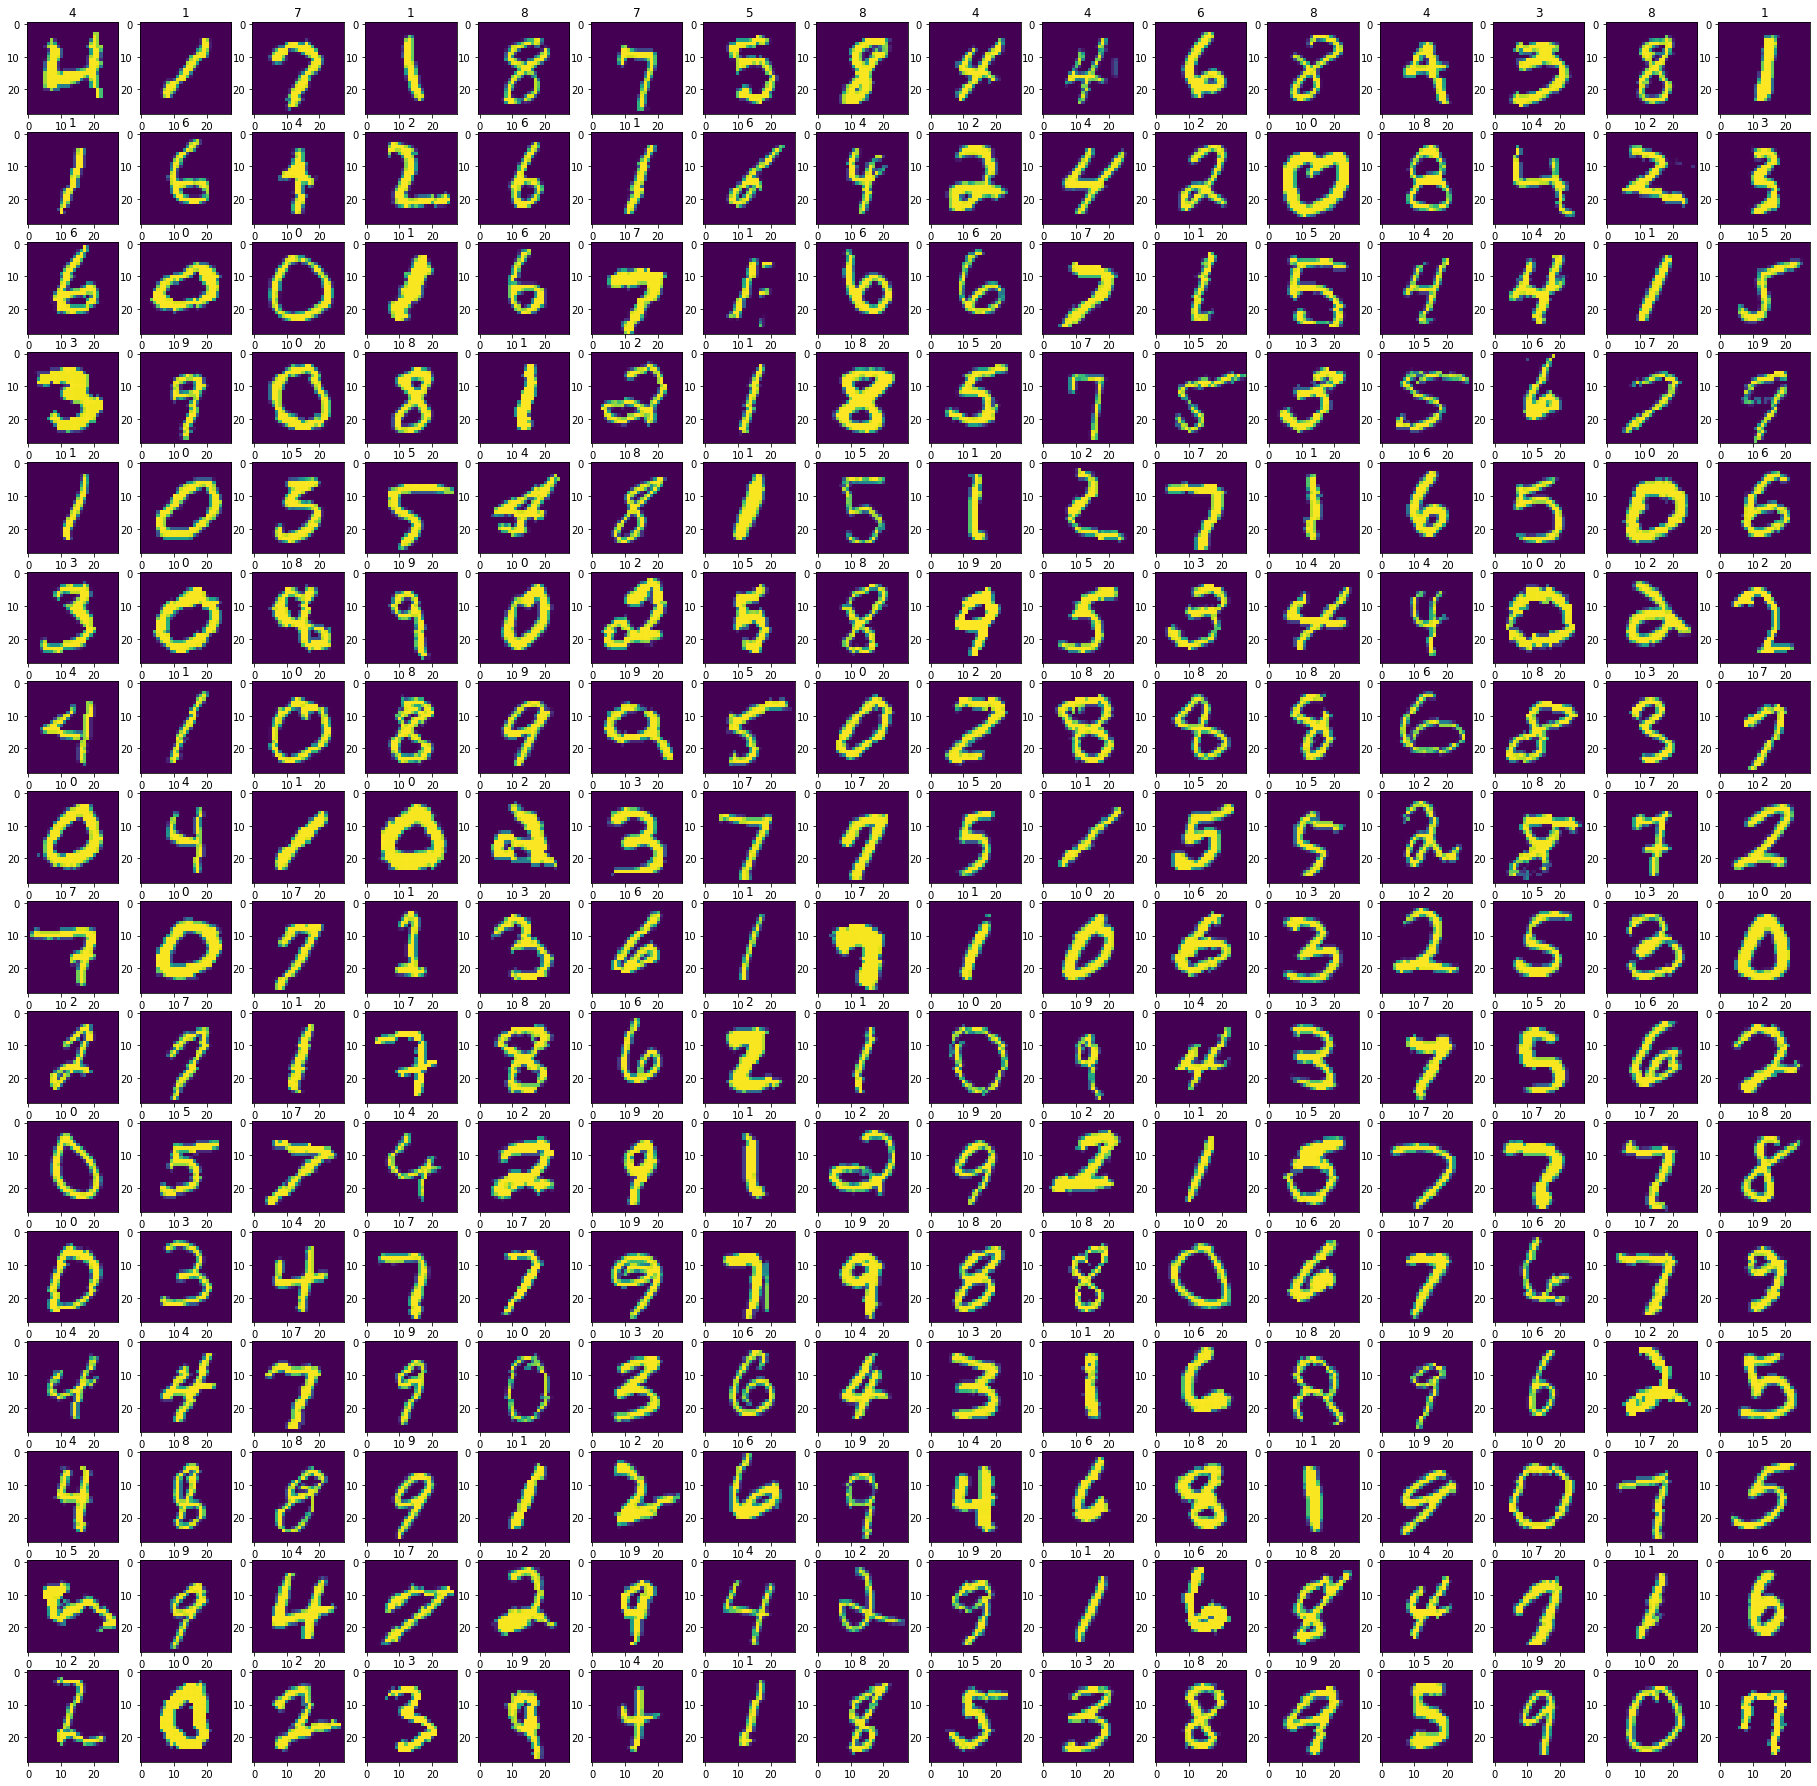

In [9]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=16, ncols=16, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*16+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0)[:,:,0])
        ax.set_title(label)

# Task 4

In [10]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()
    loss_total = 0
    
    for data in data_loader:
        
        X, y = data
        X, y = X.to(device), y.to(device)
        
        model.zero_grad()
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        loss.backward()
        
        optimizer.step()
    
    loss_avg = loss_total / len(data_loader.dataset)
    
    return loss_avg

# Task 5

In [11]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    loss_total = 0
    accuracy_total = 0
    
    for data in data_loader:

        X, y = data
        X, y = X.to(device), y.to(device)
        
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        

        y_pred = output.argmax(dim = 1, keepdim=True).to(device)
        accuracy_total += y_pred.eq(y.view_as(y_pred)).sum().item()
        
    loss_avg = loss_total / len(data_loader.dataset)
    accuracy_avg = 100.0 * accuracy_total / len(data_loader.dataset)
    
    return {'loss' : loss_avg, 'accuracy' : accuracy_avg}


In [12]:
def plot_learning_curves(loss_list, accuracy_list, best_epoch):
    """
    Plot loss evolution on training and dev sets and
    accuracy evolution on dev set
    """
    
    # Plot learning loss curve
    plt.plot(loss_list['train'], label = 'Training set')
    plt.plot(loss_list['valid'], label = 'Dev set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best epoch')
    plt.title('Loss evolution')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Plot accuracy curve         
    plt.plot(accuracy_list, color = 'g', label = 'Dev set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best epoch')
    plt.title('Accuracy evolution on validation set')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [13]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                valid_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 20, 
                best_model_root = './best_model.pth'):
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    best_valid_loss = None
    best_epoch = None
    loss_list = {'train' : list(), 'valid' : list()}
    accuracy_list = list()
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        
        start = timer()
        
        train_loss = train_single_epoch(model, optimizer, loss_function, train_loader)
        
        # Evaluate perfomance on the training set
        loss_list['train'].append(train_loss)
        
        # Evaluate perfomance on the cross-validation set
        valid_metrics = validate_single_epoch(model, loss_function, valid_loader)
        loss_list['valid'].append(valid_metrics['loss'])
        accuracy_list.append(valid_metrics['accuracy'])
        
        print('time:', timer() - start)
        print(f'Validation metrics: \n{valid_metrics}')

        lr_scheduler.step(valid_metrics['loss'])
        
        if best_valid_loss is None or best_valid_loss > valid_metrics['loss']:
            print(f'-----Best model yet, saving-----')
            best_valid_loss = valid_metrics['loss']
            best_epoch = epoch
            torch.save(model, best_model_root)
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            plot_learning_curves(loss_list, accuracy_list, best_epoch)
            return

Epoch 0
time: 28.862815132999998
Validation metrics: 
{'loss': tensor(0.0005, device='cuda:0'), 'accuracy': 94.87}
-----Best model yet, saving-----
Epoch 1
time: 28.136872623000016
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 96.76}
-----Best model yet, saving-----
Epoch 2
time: 28.178392656
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 96.39}
Epoch 3
time: 27.859871121000026
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.42}
-----Best model yet, saving-----
Epoch 4
time: 27.76484812199999
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.74}
-----Best model yet, saving-----
Epoch 5
time: 27.917234293000035
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.96}
-----Best model yet, saving-----
Epoch 6
time: 27.62151439500002
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.8}
Epoch 7
time: 27.472619070999997
Valida

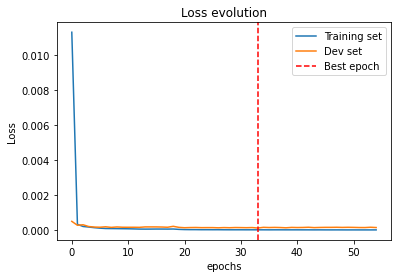

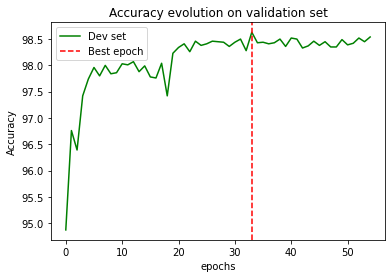

In [14]:
train_model(model, 
            train_dataset=train_dataset, 
            valid_dataset=valid_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01, max_epochs = 500, batch_size = 512, best_model_root = './mnist_cnn.pth')

# Task 6

In [15]:
class Net(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 in_channels: int = 1, 
                 out_channels = 64,
                 filters_shape: Tuple[int] = (3, 3),
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.fc1 = torch.nn.Linear(9216, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [16]:
class VGG(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 in_channels: int = 1, 
                 out_channels = 64,
                 filters_shape: Tuple[int] = (3, 3),
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_classes = num_classes
        
        # Block 1 (2 Convs + ReLU, MaxPool) Input : 28x28x1
        self.conv11 = torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)      # 28x28x64
        self.conv12 = torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)      # 28x28x64
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)                             # 14x14x64
        # Block 2 (2 Convs + ReLU, MaxPool)
        self.conv21 = torch.nn.Conv2d(out_channels, 2*out_channels, kernel_size = 3, padding = 1)   # 14x14x128
        self.conv22 = torch.nn.Conv2d(2*out_channels, 2*out_channels, kernel_size = 3, padding = 1)   # 14x14x128
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)                             # 7x7x128
        # Block 3 (3 Convs + ReLU, MaxPool)
        self.conv31 = torch.nn.Conv2d(2*out_channels, 4*out_channels, kernel_size = 3, padding = 1) # 7x7x256 
        self.conv32 = torch.nn.Conv2d(4*out_channels, 4*out_channels, kernel_size = 3, padding = 1) # 7x7x256
        self.conv33 = torch.nn.Conv2d(4*out_channels, 4*out_channels, kernel_size = 3, padding = 1) # 7x7x256
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)                             # 3x3x256
        # Block 4 (3 Convs + ReLU, MaxPool)
        self.conv41 = torch.nn.Conv2d(4*out_channels, 8*out_channels, kernel_size = 3, padding = 1) # 3x3x512
        self.conv42 = torch.nn.Conv2d(8*out_channels, 8*out_channels, kernel_size = 3, padding = 1) # 3x3x512
        self.conv43 = torch.nn.Conv2d(8*out_channels, 8*out_channels, kernel_size = 3, padding = 1) # 3x3x512
        self.maxpool4 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)                             # 1x1x512
        # Block 5 (3 Convs + ReLU, MaxPool) 
        self.conv51 = torch.nn.Conv2d(8*out_channels, 8*out_channels, kernel_size = 3, padding = 1) # 1x1x512
        self.conv52 = torch.nn.Conv2d(8*out_channels, 8*out_channels, kernel_size = 3, padding = 1) # 1x1x512
        self.conv53 = torch.nn.Conv2d(8*out_channels, 8*out_channels, kernel_size = 3, padding = 1) # 1x1x512
        # There's 5th maxpool layer in VGG-16, but we already have a vector of features so it's no use for us
        # Block 6 (3 Fully connected layers with ReLU activation) Input : vector with 512 features

        self.fc1 = torch.nn.Linear(512, 512)
        self.fc2 = torch.nn.Linear(512, 512)
        self.fc3 = torch.nn.Linear(512, self.num_classes)
        
    def forward(self, x): 
        
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = F.relu(self.conv33(x))
        x = self.maxpool3(x)
        x = F.relu(self.conv41(x))
        x = F.relu(self.conv42(x))
        x = F.relu(self.conv43(x))
        x = self.maxpool4(x)
        x = F.relu(self.conv51(x))
        x = F.relu(self.conv52(x))
        x = F.relu(self.conv53(x))

        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
        
        return x

In [17]:
custom_model = Net().to(device)

In [18]:
model_vgg = VGG().to(device)

Epoch 0
time: 26.658250085999953
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.04}
-----Best model yet, saving-----
Epoch 1
time: 26.719558001999985
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 96.56}
Epoch 2
time: 26.95088080100004
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.47}
-----Best model yet, saving-----
Epoch 3
time: 26.91292295900007
Validation metrics: 
{'loss': tensor(0.0001, device='cuda:0'), 'accuracy': 97.93}
-----Best model yet, saving-----
Epoch 4
time: 27.17111770800011
Validation metrics: 
{'loss': tensor(0.0001, device='cuda:0'), 'accuracy': 98.0}
Epoch 5
time: 26.73184121899999
Validation metrics: 
{'loss': tensor(0.0001, device='cuda:0'), 'accuracy': 98.19}
-----Best model yet, saving-----
Epoch 6
time: 26.55177863100016
Validation metrics: 
{'loss': tensor(0.0001, device='cuda:0'), 'accuracy': 98.2}
Epoch 7
time: 27.0610379740001
Validation metrics: 
{'loss': tensor(0.

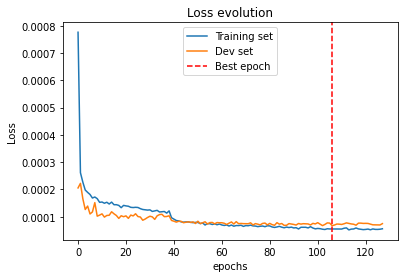

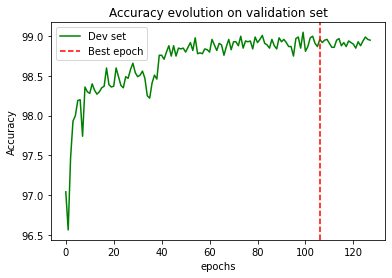

In [19]:
train_model(custom_model, 
            train_dataset=train_dataset, 
            valid_dataset=valid_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01, max_epochs = 500, batch_size = 512, best_model_root = './custom_model.pth')

Increasing number of conv layers without regularization  
harms perfomance. Architecture of VGG-16 also performs badly, network has small changes  
of loss function, but accuracy stays the same, increase of learning rate doesn't help.

In [20]:
train_model(model_vgg, 
            train_dataset=train_dataset, 
            valid_dataset=valid_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01, max_epochs = 500, batch_size = 512, best_model_root = './model_vgg.pth')

Epoch 0
time: 27.92093175500031
Validation metrics: 
{'loss': tensor(0.0046, device='cuda:0'), 'accuracy': 11.35}
-----Best model yet, saving-----
Epoch 1
time: 28.073864951999894
Validation metrics: 
{'loss': tensor(0.0046, device='cuda:0'), 'accuracy': 11.35}
-----Best model yet, saving-----
Epoch 2
time: 28.142501548999462
Validation metrics: 
{'loss': tensor(0.0046, device='cuda:0'), 'accuracy': 11.35}
Epoch 3
time: 29.06563157600067
Validation metrics: 
{'loss': tensor(0.0046, device='cuda:0'), 'accuracy': 11.35}
Epoch 4
time: 30.465151356000206
Validation metrics: 
{'loss': tensor(0.0046, device='cuda:0'), 'accuracy': 11.35}
Epoch 5
time: 29.72521679500005
Validation metrics: 
{'loss': tensor(0.0046, device='cuda:0'), 'accuracy': 11.35}
-----Best model yet, saving-----
Epoch 6
time: 29.021955148000416
Validation metrics: 
{'loss': tensor(0.0046, device='cuda:0'), 'accuracy': 11.35}
Epoch 7
time: 28.932478080000692
Validation metrics: 
{'loss': tensor(0.0046, device='cuda:0'), 'ac

KeyboardInterrupt: ignored

In [31]:
model_hyp = Net().to(device)

But decreasing learning rate  by 10 times with architecture of **Net**  
slightly improves perfomance.

Epoch 0
time: 27.32621904500047
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.27}
-----Best model yet, saving-----
Epoch 1
time: 27.14831877599954
Validation metrics: 
{'loss': tensor(0.0001, device='cuda:0'), 'accuracy': 98.25}
-----Best model yet, saving-----
Epoch 2
time: 26.568785028000093
Validation metrics: 
{'loss': tensor(0.0001, device='cuda:0'), 'accuracy': 98.31}
-----Best model yet, saving-----
Epoch 3
time: 26.39509177200034
Validation metrics: 
{'loss': tensor(9.7062e-05, device='cuda:0'), 'accuracy': 98.49}
-----Best model yet, saving-----
Epoch 4
time: 26.34112828800062
Validation metrics: 
{'loss': tensor(8.9727e-05, device='cuda:0'), 'accuracy': 98.56}
-----Best model yet, saving-----
Epoch 5
time: 26.01764615400043
Validation metrics: 
{'loss': tensor(8.8968e-05, device='cuda:0'), 'accuracy': 98.57}
-----Best model yet, saving-----
Epoch 6
time: 26.06878212399988
Validation metrics: 
{'loss': tensor(7.9821e-05, device='cuda:0'), 'accur

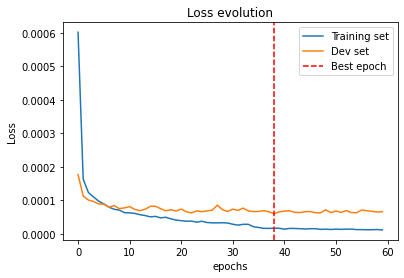

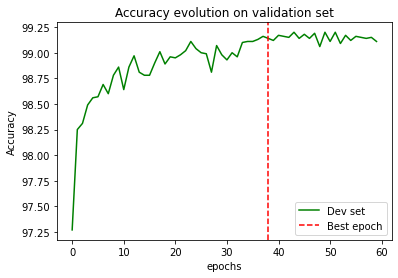

In [32]:
train_model(model_hyp, 
            train_dataset=train_dataset, 
            valid_dataset=valid_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.001, max_epochs = 500, batch_size = 512, best_model_root = './model_hyp.pth')